# Brain Tumor Classification Using PyTorch

In [66]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

## Data Preprocessing

In [171]:
# Define constants
image_size = 150
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']
data_dir = "Brain-Tumor-Classification-DataSet"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Custom Dataset
class BrainTumorDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Get image path
        img_path = self.image_paths[idx]
        
        # Check if file exists
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found: {img_path}")

        # Load image using OpenCV
        img = cv2.imread(img_path)
        if img is None:  # Handle empty or corrupted images
            raise ValueError(f"Unable to read image: {img_path}")

        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Convert NumPy array to PIL.Image
        img = Image.fromarray(img)

        # Apply transformations
        if self.transform:
            img = self.transform(img)

        # Get the label
        label = self.labels[idx]
        return img, label

# Load and preprocess data
X, y = [], []
valid_extensions = ('.jpg', '.jpeg', '.png')  # Add other extensions if needed

for label in labels:
    folderPath = os.path.join(data_dir, 'Training', label)
    for img_file in tqdm(os.listdir(folderPath)):
        # Ensure the file has a valid image extension
        if img_file.endswith(valid_extensions):
            img_path = os.path.join(folderPath, img_file)
            X.append(img_path)
            y.append(label)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# Define transformations
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
# Create datasets and dataloaders
train_dataset = BrainTumorDataset(X_train, y_train, transform=transform)
val_dataset = BrainTumorDataset(X_val, y_val, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

100%|████████████████████████████████████| 827/827 [00:00<00:00, 206297.69it/s]


## Model Definition

In [112]:
# Define model
class BrainTumorModel(nn.Module):
    def __init__(self):
        super(BrainTumorModel, self).__init__()
        self.base_model = models.efficientnet_b0(pretrained=True)
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.base_model.classifier[1].in_features, len(labels))
        )

    def forward(self, x):
        return self.base_model(x)

model = BrainTumorModel().to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

C:\Users\uditm\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\uditm\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Training Loop

Epoch 1/20, Train Loss: 0.4400, Train Accuracy: 0.8343, Val Loss: 0.2911, Val Accuracy: 0.9094
Epoch 2/20, Train Loss: 0.2402, Train Accuracy: 0.9129, Val Loss: 0.2675, Val Accuracy: 0.9373
Epoch 3/20, Train Loss: 0.1814, Train Accuracy: 0.9400, Val Loss: 0.1536, Val Accuracy: 0.9408
Epoch 4/20, Train Loss: 0.1248, Train Accuracy: 0.9520, Val Loss: 0.2398, Val Accuracy: 0.9373
Epoch 5/20, Train Loss: 0.1161, Train Accuracy: 0.9590, Val Loss: 0.2021, Val Accuracy: 0.9512
Epoch 6/20, Train Loss: 0.1021, Train Accuracy: 0.9582, Val Loss: 0.1775, Val Accuracy: 0.9408
Epoch 7/20, Train Loss: 0.0888, Train Accuracy: 0.9717, Val Loss: 0.1479, Val Accuracy: 0.9512
Epoch 8/20, Train Loss: 0.0609, Train Accuracy: 0.9768, Val Loss: 0.1764, Val Accuracy: 0.9582
Epoch 9/20, Train Loss: 0.0740, Train Accuracy: 0.9741, Val Loss: 0.2333, Val Accuracy: 0.9268
Epoch 10/20, Train Loss: 0.0564, Train Accuracy: 0.9791, Val Loss: 0.1873, Val Accuracy: 0.9652
Epoch 11/20, Train Loss: 0.0547, Train Accuracy: 

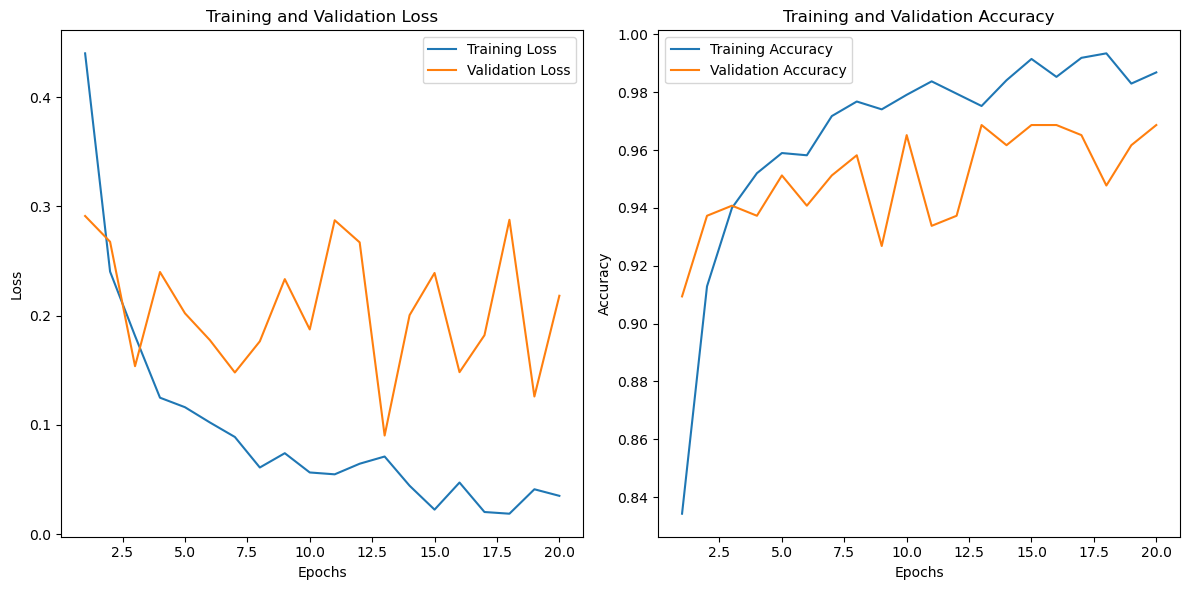

In [115]:
# Training loop with metric recording
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=20):
    best_accuracy = 0.0
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = correct / total
        train_losses.append(train_loss / len(train_loader.dataset))
        train_accuracies.append(train_accuracy)

        # Validation step
        val_loss, val_accuracy = evaluate_model(model, criterion, val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_loss/len(train_loader.dataset):.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.4f}")

        # Save the best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')

    # Return metrics for plotting
    return train_losses, train_accuracies, val_losses, val_accuracies

# Train the model and collect metrics
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model, criterion, optimizer, train_loader, val_loader, epochs=20
)

# Plotting
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 6))
# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Training Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

## Evaluation Function

In [117]:
# Evaluation function
def evaluate_model(model, criterion, val_loader):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    return val_loss / len(val_loader.dataset), val_accuracy

# Train the model
evaluate_model(model, criterion,val_loader)

(0.1552115774272133, 0.9721254355400697)

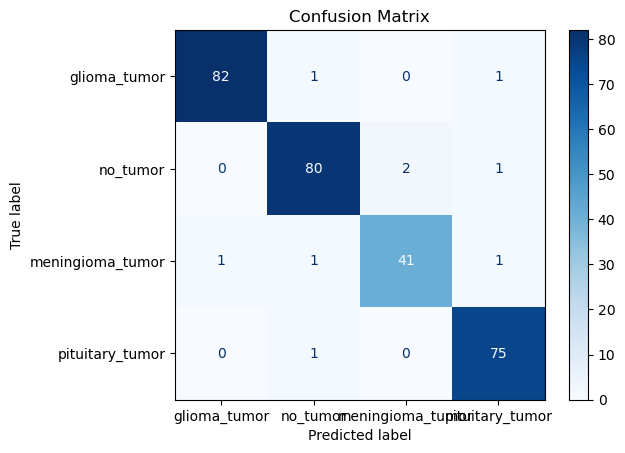

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, data_loader, class_names):
    """
    Plots the confusion matrix for a given model and data loader.

    Parameters:
        model: The trained PyTorch model.
        data_loader: DataLoader for the dataset to evaluate.
        class_names: List of class names for the confusion matrix.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# Example usage:
# Assuming `val_loader` is your validation DataLoader and `class_names` is a list of class names
class_names = labels # Update with your actual class names
plot_confusion_matrix(model, val_loader, class_names)

## Test Inference Example

In [199]:
from PIL import Image
def predict_image(model, img_path, transform, class_labels):
    """
    Predict the class of a single image.

    Args:
        model (torch.nn.Module): The trained PyTorch model.
        img_path (str): Path to the image to be tested.
        transform (callable): Transformations to be applied to the image.
        class_labels (list): List of class labels corresponding to model outputs.

    Returns:
        str: Predicted class label.
    """
    # Load the image
    img = Image.open(img_path).convert('RGB')  # Ensure RGB format
    img = transform(img).unsqueeze(0).to(device)  # Apply transformations and add batch dimension
    
    model.eval()
    with torch.no_grad():
        outputs = model(img)  # Get model predictions
        _, predicted = torch.max(outputs, 1)  # Get the index of the highest score
        predicted_class = class_labels[predicted.item()]  # Map index to class label
    
    return predicted_class

# Example usage
example_image_path = "Brain-Tumor-Classification-DataSet/Training/no_tumor/image(98).jpg"  # Replace with the actual image path

# Class labels for 4 classes
class_labels = ['glioma_tumor',  'meningioma_tumor','no_tumor', 'pituitary_tumor']  # Replace with your actual class labels

predicted_label = predict_image(model, example_image_path, transform, class_labels)
print(f"Predicted Label: {predicted_label}")

Predicted Label: no_tumor


In [201]:
def predict_image_with_debugging(model, img_path, transform, class_labels):
    img = Image.open(img_path).convert('RGB')
    img = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(img)
        print("Raw Outputs (Logits):", outputs.cpu().numpy())

        probabilities = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
        print("Probabilities:", probabilities)

        _, predicted = torch.max(outputs, 1)
        predicted_class = class_labels[predicted.item()]

    return predicted_class

In [209]:
predict_image_with_debugging(model, "Brain-Tumor-Classification-DataSet/Testing/no_tumor/image(95).jpg", transform, class_labels)

Raw Outputs (Logits): [[-1.5672454 -1.1648849  6.475993  -0.8691287]]
Probabilities: [[3.2080247e-04 4.7971203e-04 9.9855465e-01 6.4480142e-04]]


'no_tumor'